In [1]:
import tensorflow as tf
from glob import glob
import h5py

import matplotlib.pyplot as plt
from random import seed, shuffle
import numpy as np

/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/miniconda3/envs/au

In [2]:
f = h5py.File('./packed_features/unbal_train.h5', 'r')

In [3]:
all_y = f['y']
all_x = f['x']

In [4]:
N = len(all_y)
full_indices =[i for i in range(N)]

In [5]:
RANDOM_SEED = 999

seed(RANDOM_SEED)
shuffle(full_indices)

tf.set_random_seed(RANDOM_SEED)

In [16]:
test_number = 200000

indices = full_indices[:-test_number]

In [7]:
y = all_y[:,0][indices] # zero because it's the speech index

In [8]:
x = all_x.value[indices].astype('float32') 
def normalize_x_inplace(x):
    x -= 128.0
    x /= 255.0
normalize_x_inplace(x)

/home/ubuntu/miniconda3/envs/audiodream/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [9]:
features_input = tf.keras.layers.Input(shape=x[0].shape)
l = tf.keras.layers.Flatten()(features_input)
l = tf.keras.layers.Dense(64, activation='relu')(l)
l = tf.keras.layers.Dense(32, activation='relu')(l)
l = tf.keras.layers.Dense(1, activation='sigmoid')(l)

model = tf.keras.Model(features_input, l, name='AudioClassifier')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.compile('adam', loss='binary_crossentropy')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 84,097
Trainable params: 84,097
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(x, y, batch_size=128, epochs=100, validation_split=0.1, callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Train on 1657610 samples, validate on 184179 samples
Epoch 1/100
1657610/1657610 [==============================] - 36s 22us/sample - loss: 0.2175 - val_loss: 0.2527
Epoch 2/100
1657610/1657610 [==============================] - 36s 22us/sample - loss: 0.2152 - val_loss: 0.2552
Epoch 3/100
1657610/1657610 [==============================] - 37s 22us/sample - loss: 0.2136 - val_loss: 0.2564
Epoch 4/100
1657610/1657610 [==============================] - 37s 22us/sample - loss: 0.2122 - val_loss: 0.2574
Epoch 5/100
1657610/1657610 [==============================] - 36s 22us/sample - loss: 0.2108 - val_loss: 0.2598
Epoch 6/100
1657610/1657610 [==============================] - 37s 22us/sample - loss: 0.2098 - val_loss: 0.2602


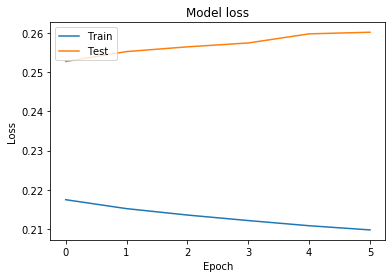

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
test_indices = full_indices[-test_number:]
test_x = all_x.value[test_indices].astype('float32')
test_y = all_y[:,0][test_indices]
normalize_x_inplace(test_x)

In [29]:
pred_y = model.predict(test_x)
threshold = 0.5
pred_boolean = np.array(pred_y.shape)
pred_boolean = pred_y > threshold

In [30]:
print(np.mean(pred_y))
print(np.std(pred_y))

pred_correctness = pred_boolean.ravel() == test_y
total = pred_correctness.shape[0]
numerator = np.sum(pred_correctness)
print(f"accuracy: {numerator/total}")

0.48640206
0.42981386
accuracy: 0.902755


In [ ]:
model.save_weights('classifier_weights')